# OSCR preconditioned high-frequency scattering

### Background

*Please note that this notebook is adjusted for larger workstations. To run it on a small laptop adjust the wavenumber parameter k to a very small value (e.g. k=5).*

A typical application for BEM is the high-frequency scattering of an incoming wave $u^{inc}$ from a sound-hard obstacle $\Omega$.

Consider the exterior Helmholtz problem

$$
\begin{align}
\Delta u^+ +k^2u^+ &= 0,~\text{in }\Omega^+\nonumber\\
\partial_nu^+|_{\Gamma} = g &= -\partial_nu^{inc}|_{\Gamma}\nonumber\\
\lim_{|\mathbf{x}\rightarrow+\infty}|\mathbf{x}|\left(\nabla u^+\cdot \frac{\mathbf{x}}{|\mathbf{x}|}-iku^+\right)&=0
\end{align}
$$

The scattered field is $u^+$ and the total field is $w = u^++u^{inc}$. The scattered field $u^{+}$ can be
represented as
$$
u^{+} = \mathcal{K}\phi,
$$
where $\mathcal{K}$ is the double layer potential operator defined by
$$
\left[\mathcal{K}\phi\right](\mathbf{x}) = \int_{\Gamma}g(\mathbf{x},\mathbf{y})\mathcal{\phi}(\mathbf{y})ds(y)
$$
with $g(\mathbf{x},\mathbf{y}) = \frac{e^{ik|\mathbf{x}-\mathbf{y}|}}{4\pi|\mathbf{x}-\mathbf{y}|}$. Here, $\phi=\gamma_0w$ is the Dirichlet boundary data of the total field.

The Burton-Miller formulation to compute $\phi$ is given as
$$
\left(\frac{1}{2}I-K+\eta D\right)\phi = \gamma_0 u^{inc}+\eta \gamma_1u^{inc}
$$
for some $\eta\neq 0$. $K$ is the double layer boundary operator and $D$ the hypersingular operator.

A perfect choice for $\eta$ is the exterior Neumann-To-Dirichlet map $V_{NtD}$ with the property
$$
\frac{1}{2}I-K-V_{NtD}D = I.
$$
However, this is a complicated non-local operator.  The idea of OSRC is to use the pseudodifferential operator approximation
$$
V_{NtD}\approx \frac{1}{ik}\left(1+\frac{\Delta_{\Gamma}}{(k+i\epsilon)^2}\right)^{-\frac{1}{2}}
$$
for a regularization parameter $\epsilon>0$ and to localize the squareroot operator by a Pad&eacute; approximation. Details of this OSRC preconditioning are given for example in *X. Antoine, M. Darbase, "Generalized combined field integral equations for the iterative solution of the three-dimensional Helmholtz equation", ESAIM: Mathematical Modelling and Numerical Analysis, 41 (2007), pp. 147--167.*

BEM++ implements approximate Dirichlet-To-Neumann and Neumann-To-Dirichlet maps. This notebook demonstrates how to use these for high-frequency scattering computations in BEM++.


### Implementation

In the following we implement an OSRC Burton-Miller formulation for high-frequency scattering. We start with the usual imports.

In [1]:
import bempp.api
import numpy as np

INFO:BEMPP:Dolfin could not be imported. FEM/BEM coupling with FEniCS not available.


The following defines the wavenumber k and the Dirichlet and Neumann data of the incident plane wave.

In [2]:
k = 20

def dirichlet_fun(x, n, domain_index, result):
    result[0] = np.exp(1j * k * x[0])

def neumann_fun(x, n, domain_index, result):
    result[0] = 1j * k * n[0] * np.exp(1j *k * x[0])

For this example we will use an elongated ellipsoid. The element size is chosen to roughly correspond to 10 elements per wavelength. The function space consists of continuous, piecwise linear basis functions. The OSRC preconditioner only works for continuous function spaces as it assembles a Laplace-Beltrami operator.

In [3]:
h = 2*np.pi/(10 * k)
grid = bempp.api.shapes.ellipsoid(3, 1, 1, h=h)
space = bempp.api.function_space(grid, "P", 1)
print("The space has {0} dofs".format(space.global_dof_count))

The space has 37481 dofs


We can now assemble the Burton-Miller operator.

In [4]:
identity = bempp.api.operators.boundary.sparse.identity(space, space, space)
dlp = bempp.api.operators.boundary.helmholtz.double_layer(space, space, space, k)
hyp = bempp.api.operators.boundary.helmholtz.hypersingular(space, space, space, k, use_slp=True)
ntd = bempp.api.operators.boundary.helmholtz.osrc_ntd(space, k)

burton_miller = .5 * identity - dlp - ntd * hyp

In the above operator assembly we were allowed to directly multiply operators. BEM++ automatically assembles the correct mass matrix transformations for this product to make sense. For the assembly of the hypersingular operator we used the parameter ``use_slp=True``. This does not assemble the hypersingular operator directly but instead describes the hypersingular operator in terms of an underlying Helmholtz single layer operator. This approach takes more memory but the H-Matrix assembly is significantly faster. We still need to assemble the right-hand side.

In [5]:
dirichlet_grid_fun = bempp.api.GridFunction(space, fun=dirichlet_fun)
neumann_grid_fun = bempp.api.GridFunction(space, fun=neumann_fun)
rhs_fun = dirichlet_grid_fun - ntd * neumann_grid_fun

INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (37481,37481). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.86E-01 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (37481,37481). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.17E-01 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (37481,37481). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.39E-01 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (37481,37481). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.63E-01 sec.
INFO:BEMPP:LAPLACE_BELTRAMI. START ASSEMBLY. Dim: (37481,37481). Assembly Type: sparse
INFO:BEMPP:LAPLACE_BELTRAMI. FINISHED ASSEMBLY. Time: 2.38E-01 sec.


We can now solve the Burton-Miller formulation using GMRES. We will use a ``strong form`` discretization which automatically performs mass matrix preconditioning.

In [6]:
discrete_op = burton_miller.strong_form()
rhs_coefficients = rhs_fun.coefficients

from scipy.sparse.linalg import gmres

it_count = 0
def iteration_counter(x):
    global it_count
    it_count += 1
    
x, info = gmres(discrete_op, rhs_coefficients, callback=iteration_counter)
print("The linear system was solved in {0} iterations".format(it_count))

# The following grid function stores the computed boundary data of the total field.
total_field = bempp.api.GridFunction(space, coefficients=x)

INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (37481,37481). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 3.04E-01 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (37481,37481). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.59E-01 sec.
INFO:BEMPP:DLP. START ASSEMBLY. Dim: (37481,37481). Assembly Type: hmat
INFO:BEMPP:DLP. FINISHED ASSEMBLY. Time: 1.04E+02 sec. Mem Size (Mb): 8.06E+02. Compression: 3.76E-02
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (37481,37481). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.40E-01 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (224874,224874). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.63E-01 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (224874,224874). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.07E-01 sec.
INFO:BEMPP:SLP. START ASSEMBLY. Dim: (224874,224874). Assembly Type: hmat
INFO:BEMPP:SLP. FINISHED ASSEMBLY. Time: 3.01E+02 sec

The linear system was solved in 7 iterations


We now want to plot the radar cross section in the $z=0$ plane. To compute it we use the far-field operators implemented in BEM++.

INFO:BEMPP:POTENTIAL OPERATOR ASSEMBLY START. Number of points: 400. Space dimension: 37481. Assembly type: hmat 
INFO:BEMPP:FINISHED POTENTIAL OPERATOR ASSEMBLY. Time: 9.51E+00 sec.


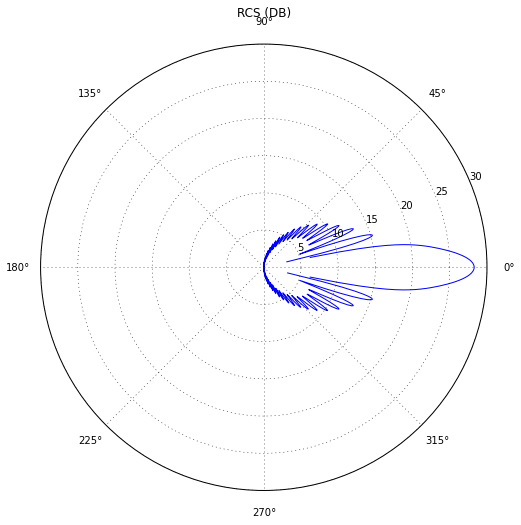

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

theta = np.linspace(-np.pi/2, np.pi/2, 400)
points = np.array([np.cos(theta), np.sin(theta), np.zeros(len(theta))])

dlp_far_field = bempp.api.operators.far_field.helmholtz.double_layer(space, points, k)
far_field = dlp_far_field * total_field
max_incident = np.abs(dirichlet_grid_fun.coefficients).max()
radiation_pattern = (np.abs(far_field/max_incident)**2).ravel()
db_pattern = 10 * np.log10(4 * np.pi * radiation_pattern)

plt.polar(theta, db_pattern)
plt.title('RCS (DB)')